# **Function Calling with Llama 3.1 Models**
Welcome to this notebook exploring function calling capabilities with Meta's Llama 3.1 models. Llama 3.1, the latest iteration in the Llama family, introduces native support for function calling, marking a significant advancement in the model's capabilities and potential applications.

![Llamas](imgs/llama-pic.jpeg)

### **What's New in Llama 3.1?**
Llama 3.1 brings several exciting improvements:
- Native Function Calling: Built-in support for generating structured JSON outputs that can be used with various APIs.
- Multilingual Support: Expanded language understanding across 8 languages, including English, French, German, Hindi, Italian Portuguese, Spanish, and Thai.
- Improved Performance: Benchmarking in the GPT-4+ class, competitive with both GPT-4 and Claude 3.5 Sonnet.
- Increased Context Window: The 8B and 70B models now support a 128,000 token context.

### **Function Calling Overview**
Function calling, also known as tool use, allows Llama 3.1 to interact with external tools or APIs by generating structured outputs. This capability enables more complex, multi-step interactions between the model and available tools, enhancing its problem-solving abilities and practical applications.

### **Amazon Bedrock**
![bedrock](imgs/bedrock-img.png)

Amazon Bedrock is a fully managed service that provides access to a wide range of powerful foundation models (FMs) through a unified API. It offers models from leading AI companies like Mistral, Anthropic, AI21 Labs, Cohere, Stability AI, and Amazon's own Titan models.

- **Unified API**: Bedrock provides a single API endpoint to access different models, simplifying integration and allowing developers to experiment with or switch between models with minimal code changes.
- **Serverless and Fully Managed**: As a fully managed service, Bedrock eliminates the need for users to handle infrastructure management, making it easier to build and deploy generative AI applications.
- **Model Customization**: Users can customize models with their own data using techniques such as fine-tuning and Retrieval Augmented Generation (RAG).
- **Security and Privacy**: Bedrock offers built-in security features, ensuring data privacy and compliance with various standards. It follows best practices like encrypting all data and preventing third parties from accessing user data.
- **Agents for Complex Tasks**: Bedrock allows the creation of agents that can plan and execute multi-step tasks using enterprise systems and data sources.
- **Integration with AWS Services**: Bedrock can be easily integrated with other AWS services and existing applications.
- **Model Evaluation**: A new capability that helps customers assess, compare, and select the best model for their application.
- **Guardrails**: Bedrock provides tools to implement safeguards tailored to application needs and aligned with responsible AI policies.
- **Custom Model Import**: A new feature that allows customers to import and access their own custom models as a fully managed API in Bedrock.
- **Playground Environment**: Bedrock offers Playgrounds (text, chat, and image) to compare models and experiment with different options

## Agentic workflow

Wolfram Alpha API is free (for non-commercial usage) that brings expert-level knowledge and capabilities to the broadest possible range of people—spanning all professions and education levels. In order to send request to the API, we need to create an account and get the API key (App ID).

1) To get API key we will first create Wolfram ID at [Create an Account](https://account.wolfram.com/login/create). 
2) After the account is created, you can navigate to the [Developer Portal](https://developer.wolframalpha.com/access) and generate an API Key. After that you will be presented with an App ID, which you will use for this notebook.

In this notebook, we showcase a few examples that demonstrate function calling using the Converse API. These examples illustrate how customers can execute API calls for various use cases, including text generation, mathematical reasoning, and image generation

In [ ]:
%pip install boto3==1.35.11 colorama==0.4.6 --quiet 

## Building an agentic workflow

### 1. Defining a Wolfram Alpha function

Before we start working with LLama models on Bedrock, let's write a simple code snippet to query Wolfram Alpha.  The following function uses the `urllib` package to send api requests for matching queries on Wolfram Alpha Platform based on a search term.

In [1]:
import io
import os
import json
from typing import List


import boto3
import getpass
import requests
import urllib.parse
from PIL import Image
from colorama import Fore
from datetime import datetime
from botocore.exceptions import ClientError


session = boto3.Session()
region = session.region_name

Before you continue, please add your App ID below:

In [2]:
app_id = getpass.getpass('Wolfram Alpha App ID:')

Wolfram Alpha App ID: ········


In [3]:
question = "Convert 25 miles per hour to meters per second"

print(f"{Fore.YELLOW}Question: {question}")

query = urllib.parse.quote_plus(question)
query_url = f"http://api.wolframalpha.com/v2/query?" \
             f"appid={app_id}" \
             f"&input={query}" \
             f"&format=plaintext" \
             f"&output=json"

r = requests.get(query_url).json()

outputs_with_reference = []
outputs_without_reference = []
if 'pods' in r["queryresult"]:
    pods = r["queryresult"]["pods"]

    for idx, pod in enumerate(pods):
        subpods = pod['subpods'][0]
        if 'datasources' in subpods:
            datasource = ", ".join(subpods["datasources"]["datasource"])
        else:
            datasource = "NA"
        if 'microsources' in subpods:
            microsource = subpods["microsources"]["microsource"]
        else:
            microsource = "NA"
        plaintext = subpods["plaintext"]

        if datasource == "NA":
            outputs_without_reference.append(plaintext)
        elif (datasource != "NA") and len(plaintext) > 0:
            outputs_with_reference.append(plaintext)
        print(f"{Fore.BLUE}Result {idx + 1}: '{plaintext}' from {datasource} ({microsource}).")

    if len(outputs_with_reference) > 0:
        best_result = outputs_with_reference[0]
    else:
        best_result = outputs_without_reference[1]
else:
    best_result = "No results were found"

print(f"{Fore.GREEN}============================")
print(f"Best Result: {best_result}")
print(f"============================")

Question: Convert 25 miles per hour to meters per second
Result 1: 'convert 25 mph (miles per hour) to meters per second' from NA (NA).
Result 2: '11.18 m/s (meters per second)' from NA (NA).
Result 3: '600 mi/d (miles per day)' from NA (NA).
Result 4: ' ≈ 0.9 × maximum speed of the world's fastest human (fastest 20 meter split by Usain Bolt in the 100-meter dash) ( 12.35 m/s )' from NA (NA).
Result 5: 'speed' from NA (NA).
Result 6: '[length] [time]^(-1)' from NA (NA).
Result 7: 'Time to travel 1 meter from t = d/v:
 | 89 ms (milliseconds)' from NA (NA).
Best Result: 11.18 m/s (meters per second)


The code utilizes the Wolfram Alpha Full Results API to perform the unit conversion of `25 miles per hour to meters per second`. It makes a GET request to the Wolfram Alpha API endpoint at http://api.wolframalpha.com/v2/query, passing several parameters:

1. The `App ID` for authentication to access the Wolfram Alpha API.
2. The input query `25 miles per hour to meters per second` in the `input` field.
3. The `format` parameter set to `plaintext` to request the result in text format, rather than an image.
4. The `output` parameter set to `JSON` to receive the response in JSON format, instead of the default XML.

The response from Wolfram Alpha can be quite complex, so the easiest approach is to first print out the full response and then identify the useful fields to extract the best result.

### 2. Writing the tool definition
Next up, we need to define our tool using the proper JSON Schema format.  This is a very simple tool definition because the function expects a single argument: the `query` string.  

In [4]:
toolConfig = {
  "tools": [
    {
      "toolSpec": {
        "name": "run_math_operations",
        "description": "run_math_operations",
        "inputSchema": {
          "json": {
            "type": "object",
            "properties": {
              "query": {
                "type": "string",
                "description": "User's question"
              }
            },
            "required": ["query"]
          }
        }
      }
    }
  ]
}

Below we incorporate our prior code as a function within the `ToolList` class.

In [5]:
class ToolsList:
    app_id = app_id
    
    def run_math_operations(self, query) -> str:
        "A tool to respond to math operations using Wolfram Alpha API"
        query = urllib.parse.quote_plus(query)
        query_url = f"http://api.wolframalpha.com/v2/query?" \
                     f"appid={self.app_id}" \
                     f"&input={query}" \
                     f"&format=plaintext" \
                     f"&output=json"

        r = requests.get(query_url).json()

        outputs_with_reference = []
        outputs_without_reference = []
        if 'pods' in r["queryresult"]:
            pods = r["queryresult"]["pods"]

            for idx, pod in enumerate(pods):
                subpods = pod['subpods'][0]
                if 'datasources' in subpods:
                    datasource = ", ".join(subpods["datasources"]["datasource"])
                else:
                    datasource = "NA"
                if 'microsources' in subpods:
                    microsource = subpods["microsources"]["microsource"]
                else:
                    microsource = "NA"
                plaintext = subpods["plaintext"]

                if datasource == "NA":
                    outputs_without_reference.append(plaintext)
                elif (datasource != "NA") and len(plaintext) > 0:
                    outputs_with_reference.append(plaintext)

            if len(outputs_with_reference) > 0:
                best_result = outputs_with_reference[0]
            else:
                best_result = outputs_without_reference[1]
        else:
            best_result = "No results were found"
        return best_result

### 3. Provide Llama 3.1 with the tool and user prompt

Next, we'll tell Llama 3.1 it has access to the Wolfram Alpha tool and ask it to answer a question we know it could struggle to answer without the tool, like `Convert 25 miles per hour to meters per second`

In [6]:
modelId = 'meta.llama3-1-70b-instruct-v1:0'
# modelId = 'meta.llama3-1-405b-instruct-v1:0'
# modelId = 'meta.llama3-1-8b-instruct-v1:0'

bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name=region
)

First, let's try it without the tool:

In [7]:
question = "Convert 25 miles per hour to meters per second"
messages = [{"role": "user", "content": [{"text": question}]}]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"temperature": 0.0, "maxTokens": 2048},
}

response = bedrock_client.converse(**converse_api_params)
print(f"{Fore.GREEN}Response:\n {response['output']['message']['content'][0]['text']}")

Response:
 

To convert 25 miles per hour to meters per second, we need to perform two conversions:

1. Miles to meters:
1 mile = 1609.34 meters
25 miles = 25 x 1609.34 = 40,233.5 meters
2. Hours to seconds:
1 hour = 3600 seconds
25 hours = 25 x 3600 = 90,000 seconds

Now, we can convert 25 miles per hour to meters per second:

25 miles/hour = 40,233.5 meters / 90,000 seconds
= 0.447 meters/second

Therefore, 25 miles per hour is equivalent to approximately 0.447 meters per second.


**The expected answer is 11.18 m/s (meters per second). As we can see, the model did not get the user's query right.**

Now, let's make use of the tool.

In [8]:
question = "Convert 25 miles per hour to meters per second"
messages = [{"role": "user", "content": [{"text": question}]}]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"temperature": 0.0, "maxTokens": 2048},
    "toolConfig": toolConfig
}

response = bedrock_client.converse(**converse_api_params)

### 4. Llama 3.1 uses the tool (API response)

Let's look at the response we got back.  Llama 3.1 wants to use our tool!

In [9]:
print(f"{Fore.GREEN}Response:\n {response['output']['message']['content']}")

Response:
 [{'toolUse': {'toolUseId': 'tooluse_AwxlWiqMQNGue4alCXe62Q', 'name': 'run_math_operations', 'input': {'query': '25 miles per hour to meters per second'}}}]


Llama 3.1's response contains a block with the tool use: 

* A `toolUse` value calling our `run_math_operations` tool with the `query` "25 miles per hour to meters per second"

```
{'toolUse': {'toolUseId': 'tooluse_T-LlliJ1RNWKUv3q1GV3kw',
   'name': 'run_math_operations',
   'input': {'query': '25 miles per hour to meters per second'}}}
```


### 5. Extract tool input(s), run code, and return results (API request)

Now that Llama 3.1 has responded telling us it wants to use a tool, it's time for us to actually run the underlying functionality AND respond back to Llama 3.1 with the corresponding Wolfram Alpha content.

**We need to pay special attention to make sure we update our `messages` list**

We'll begin by updating our `messages` list to include Llama 3.1's most recent response:

In [10]:
messages.append({"role": "assistant", "content": response['output']['message']['content']})

In [11]:
print(f"{Fore.GREEN}Messages:\n")
for m in messages:
    print(f"{m}")

Messages:

{'role': 'user', 'content': [{'text': 'Convert 25 miles per hour to meters per second'}]}
{'role': 'assistant', 'content': [{'toolUse': {'toolUseId': 'tooluse_AwxlWiqMQNGue4alCXe62Q', 'name': 'run_math_operations', 'input': {'query': '25 miles per hour to meters per second'}}}]}


Next, we'll extract the specific tool and arguments that Llama 3.1 wants to use:

In [12]:
# This is a simple way to get the tool use information
tool_use = response['output']['message']['content'][-1]
tool_id = tool_use['toolUse']['toolUseId']
tool_name = tool_use['toolUse']['name']
tool_inputs = tool_use['toolUse']['input']

print(f"{Fore.GREEN}Tool Id: {tool_id}")
print(f"{Fore.GREEN}Tool name: {tool_name}")
print(f"{Fore.GREEN}Tool input {tool_inputs}")

Tool Id: tooluse_AwxlWiqMQNGue4alCXe62Q
Tool name: run_math_operations
Tool input {'query': '25 miles per hour to meters per second'}


Next, we'll make sure Llama 3.1 is calling the `run_math_operations` tool we're expecting. We'll take the `query` Llama 3.1 came up with and pass that to the `run_math_operations` function we wrote earlier.

In [13]:
if tool_name == "run_math_operations":
    search_term = tool_inputs["query"]
    tool_result = getattr(ToolsList(), tool_name)(**tool_inputs) or ""
    print(f"{Fore.GREEN}Searching Wolfram Alpha for: {search_term}")
    print(f"{Fore.GREEN}WOLFRAM ALPHA RESPONSE:")
    print(f"{Fore.GREEN}{tool_result}")

Searching Wolfram Alpha for: 25 miles per hour to meters per second
WOLFRAM ALPHA RESPONSE:
11.18 m/s (meters per second)


Now that we've executed the function Llama 3.1 wanted us to call, it's time to respond back to Llama 3.1 with the Wolfram Alpha  results.

As we know, when Llama 3.1 wants to use a tool, it responds to us with a `stop_reason` of `tool_use` and one or more `tool_use` content blocks in the API response that include:
* `id`: A unique identifier for this particular tool use block. This will be used to match up the tool results later.
* `name`: The name of the tool being used.
* `input`: An object containing the input being passed to the tool, conforming to the tool's `input_schema`.

Once we have executed our underlying tool function, we need to respond back to Llama 3.1 with a particular format as well. Specifically, to continue the conversation, we need to send a new message with the **role of `user`** and a content block **containing the `tool_result` type**, along with the following information:
* `toolUseId`: The id of the tool use request this is a result for.
* `content`: The result of the tool, as a string (e.g. "content": "11.18 m/s") or list of nested content blocks (e.g. "content": [{"type": "text", "text": "11.18 m/s"}]\). 
* `status` (optional): Set to **success** or **error** based on the tool execution results.

Here's an example of what a properly formatted `toolResult` message looks like: 

```json
{
    "role": "user",
    "content": [
        {
            "toolResult": {
                "toolUseId": "tooluse_nsHIrq58TYC_GGssJEo9Xw",
                "content": [
                    {
                        "json": {
                            "query": "11.18 m/s"
                        }
                    }
                ]
            }
        }
    ]
}
```

Let's do this now for our Wolfram Alpha example. We need to form a properly constructed tool response message to send our Wolfra Alpha result back to Llama 3.1:

In [14]:
tool_response = {
    "role": "user",
    "content": [
        {
            "toolResult": {
                "toolUseId": tool_id,
                "content": [
                    {
                        "text": tool_result
                        }
                ]
            }
        }
    ]
}

In [15]:
print(f"{Fore.GREEN}{tool_response}")

{'role': 'user', 'content': [{'toolResult': {'toolUseId': 'tooluse_AwxlWiqMQNGue4alCXe62Q', 'content': [{'text': '11.18 m/s (meters per second)'}]}}]}


Next, we need to add our `tool_response` message to our messages list: 

In [16]:
messages.append(tool_response)

In [17]:
print(f"{Fore.GREEN}Messages:\n")
for m in messages:
    print(f"{m}")

Messages:

{'role': 'user', 'content': [{'text': 'Convert 25 miles per hour to meters per second'}]}
{'role': 'assistant', 'content': [{'toolUse': {'toolUseId': 'tooluse_AwxlWiqMQNGue4alCXe62Q', 'name': 'run_math_operations', 'input': {'query': '25 miles per hour to meters per second'}}}]}
{'role': 'user', 'content': [{'toolResult': {'toolUseId': 'tooluse_AwxlWiqMQNGue4alCXe62Q', 'content': [{'text': '11.18 m/s (meters per second)'}]}}]}


Our `messages` list now looks like this: 

* User: `Convert 25 miles per hour to meters per second`
* Assistant: I want to use the `run_math_operations` tool with `query` "25 miles per hour to meters per second"
* User: Here's the tool result that contains the Wolfram Alpha you asked for

### 5. Llama 3.1 uses the tool result to formulate a response: (API response)

Finally, we can use our updated `messages` list and send a new request to Llama 3.1:

In [18]:
converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"temperature": 0.0, "maxTokens": 1000},
    "toolConfig": toolConfig #The toolConfig which contains our query_wolframalpha_tool details
}

follow_up_response = bedrock_client.converse(**converse_api_params)

In [19]:
print(f"{Fore.GREEN}Messages:\n {follow_up_response['output']['message']['content'][0]['text']}")

Messages:
 

The conversion of 25 miles per hour to meters per second is 11.18 m/s.


Llama 3.1 now has the information needed to answer the initial question and responds back with:

> 'The conversion of 25 miles per hour to meters per second is 11.18 m/s.'

We have now completed all 5 steps of the process! 

## Working with multiple tool use

Now that we have experimented with tool use, it is time to incorporate more functions into our tool use list. Below, we include a new tool called `render_plots` to help us generate a plot based on a given mathematical function.

In [20]:
toolConfig = {
  "tools": [
    {
      "toolSpec": {
        "name": "run_math_operations",
        "description": "Run math operations",
        "inputSchema": {
          "json": {
            "type": "object",
            "properties": {
              "query": {
                "type": "string",
                "description": "User's question"
              }
            },
            "required": ["query"]
          }
        }
      }
    },
    {
      "toolSpec": {
        "name": "render_plots",
        "description": "Render functions as a plot",
        "inputSchema": {
          "json": {
            "type": "object",
            "properties": {
              "function": {
                "type": "string",
                "description": "User's function to be plotted"
              }
            },
            "required": ["function"]
          }
        }
      }
    }
  ]
}

Below we incorporate our prior code as a function within the ToolList class.

In [21]:
class ToolsList:
    app_id = app_id
    
    def run_math_operations(self, query) -> str:
        "A tool to respond to math operations using Wolfram Alpha API"
        query = urllib.parse.quote_plus(query)
        query_url = f"http://api.wolframalpha.com/v2/query?" \
                     f"appid={self.app_id}" \
                     f"&input={query}" \
                     f"&format=plaintext" \
                     f"&output=json"

        r = requests.get(query_url).json()

        outputs_with_reference = []
        outputs_without_reference = []
        if 'pods' in r["queryresult"]:
            pods = r["queryresult"]["pods"]

            for idx, pod in enumerate(pods):
                subpods = pod['subpods'][0]
                if 'datasources' in subpods:
                    datasource = ", ".join(subpods["datasources"]["datasource"])
                else:
                    datasource = "NA"
                if 'microsources' in subpods:
                    microsource = subpods["microsources"]["microsource"]
                else:
                    microsource = "NA"
                plaintext = subpods["plaintext"]

                if datasource == "NA":
                    outputs_without_reference.append(plaintext)
                elif (datasource != "NA") and len(plaintext) > 0:
                    outputs_with_reference.append(plaintext)

            if len(outputs_with_reference) > 0:
                best_result = outputs_with_reference[0]
            else:
                best_result = outputs_without_reference[1]
        else:
            best_result = "No results were found"
        return best_result
    
    def render_plots(self, function) -> str:
        "A tool to render functions as a plot using Wolfram Alpha API"
        query = f"plot {function}"
        query_url = f"http://api.wolframalpha.com/v2/query?" \
                    f"appid={self.app_id}" \
                    f"&input={query}" \
                    f"&output=json" \
                    f"&includepodid=3DPlot" \
                    f"&includepodid=ContourPlot"

        r = requests.get(query_url).json()

        pods = r["queryresult"]["pods"]
        plot_3d_url = pods[0]["subpods"][0]["img"]["src"]
        plot_contour_url = pods[1]["subpods"][0]["img"]["src"]
        img_data = requests.get(plot_3d_url).content

        return img_data

## Improving the code

At a bare minimum, we probably want to put all the above code into a reusable function so we can try it out a few times. In our code below we also automated the code to run more than one tool.

In [22]:
class BedrockLLM():
    def __init__(
        self,
        region_name: str = 'us-west-2',
        model_id: str = "meta.llama3-1-70b-instruct-v1:0",
        temperature: float = 0.7,
        max_tokens: int = 2048,
        top_p: float = 0.95
     ) -> None:
        self.bedrock_client = boto3.client('bedrock-runtime', region_name=region_name)
        self.model_id = model_id
        self.temperature = temperature
        self.max_tokens = max_tokens
        self.top_p = top_p

    def invoke(
        self, 
        prompt: str = "",
        system_prompt: str = None,
        messages: List = [],
        tool_config: dict = {},
        ToolsList: object = object()
    ) -> str:
        """
        Sends messages to a model.
        Args:
            prompt (str): The prompt to send to the model.
            system_prompt (str): The system prompt for the model to use.
            messages (list): The messages to send to the model.
            tool_config (dict): A dictionary with a list of tools available for the model.
            ToolsList (object): Python Class with tools that can be executed by the model.
        Returns:
            response (str|bytes): The conversation that the model generated.
        """

        print(f"{Fore.BLUE}Generating message with model {self.model_id}")
        
        if len(messages) == 0:
            messages = [
                {
                    "role": "user",
                    "content": [{"text": prompt}]
                }
            ]

        # Base inference parameters to use.
        inference_config = {
            "temperature": self.temperature,
            "maxTokens": self.max_tokens,
            "topP": self.top_p,
        }
        
        params = {
            "modelId": self.model_id,
            "messages": messages,
            "inferenceConfig": inference_config
        }
        
        if system_prompt:
            # Setup the system prompts and messages
            system_prompts = [{"text": system_prompt}]
            params["system"] = system_prompts
        
        if len(tool_config) > 0:
            params["toolConfig"] = tool_config

        # Send the message.
        response = self.bedrock_client.converse(**params)
        
        # Return the response
        assistant_message = response['output']['message']
        
        # Add the intermediate output to the prompt:
        messages.append(assistant_message)

        #If the LLM stops because it wants to use a tool:
        if response['stopReason'] == "tool_use":
            function_calling = next((c['toolUse'] for c in assistant_message['content'] if 'toolUse' in c), None)
            # Get the tool name and arguments:
            tool_name = function_calling['name']
            tool_args = function_calling['input'] or {}
            
            print(f"{Fore.BLUE}Parameters for searching in Wolfram Alpha: {tool_args}")

            # Run the tool:
            tool_response = getattr(ToolsList(), tool_name)(**tool_args) or ""
            if tool_response:
                tool_status = 'success'
            else:
                tool_status = 'error'
            
            if type(tool_response) is str:
                print(f"{Fore.BLUE}Tool response:")
                print(f"{Fore.BLUE}{tool_response}")
                # Add the tool result to the prompt:
                messages.append(
                    {
                        "role": "user",
                        "content": [
                            {
                                'toolResult': {
                                    'toolUseId': function_calling['toolUseId'],
                                    'content': [
                                        {
                                            "text": tool_response
                                        }
                                    ],
                                    'status': tool_status
                                }
                            }
                        ]
                    }
                )


                params['messages'] = messages

                # Invoke the model one more time:
                response = self.bedrock_client.converse(**params)

                # Return the response
                assistant_message = response['output']['message']
            else:
                print(f"{Fore.BLUE}Tool response is an image")
                assistant_message = None

        # Log token usage.
        token_usage = response['usage']
        print(f"{Fore.BLUE}Input tokens: {token_usage['inputTokens']}")
        print(f"{Fore.BLUE}Output tokens: {token_usage['outputTokens']}")
        print(f"{Fore.BLUE}Total tokens: {token_usage['totalTokens']}")
        print(f"{Fore.BLUE}Stop reason: {response['stopReason']}")
        
        if assistant_message:
            output = assistant_message['content'][0]['text']
        else:
            output = tool_response

        return output

## Improving our prompt

As we saw in a previous lesson, sometimes Llama 3.1 is overly eager to use tools.  An easy wasy to fix this is through the system prompt.


We could add a system prompt that looks something like this:

In [23]:
system_prompt = """
    You will be asked a question by the user.
    If answering the question requires data you were not trained on, you can use the tools provided to you to better answer user's question. 
    If you can answer the question without needing to get more information, please do so. 
    Only call the tool when needed.
    """

In [24]:
llm = BedrockLLM()

### 1. General knowledge

Let's try asking a question:

In [25]:
response = llm.invoke(
    prompt="What is the capital of France?",
    system_prompt=system_prompt,
    tool_config=toolConfig,
    ToolsList=ToolsList
)

if type(response) is str:
    print(f"{Fore.GREEN}Response:\n {response}")
else:
    img = Image.open(io.BytesIO(response))
    img.show()

Generating message with model meta.llama3-1-70b-instruct-v1:0
Input tokens: 185
Output tokens: 9
Total tokens: 194
Stop reason: end_turn
Response:
 

The capital of France is Paris.


It worked! Llama 3.1 did not use our tool when it wasn't needed.  Let's make sure it still works when answering questions that do require access to more complex reasoning:

### 2. Tool use - Mathematical reasoning

In [26]:
response = llm.invoke(
    prompt="Simplify the expression (2x^2 + 3x - 4)/(x - 1)",
    system_prompt=system_prompt,
    tool_config=toolConfig,
    ToolsList=ToolsList
)
if type(response) is str:
    print(f"{Fore.GREEN}Response:\n {response}")
else:
    img = Image.open(io.BytesIO(response))
    img.show()

Generating message with model meta.llama3-1-70b-instruct-v1:0
Parameters for searching in Wolfram Alpha: {'query': 'simplify (2x^2 + 3x - 4)/(x - 1)'}
Tool response:
(2 x^2)/(x - 1) + (3 x)/(x - 1) - 4/(x - 1)
Input tokens: 317
Output tokens: 36
Total tokens: 353
Stop reason: end_turn
Response:
 

The simplified expression is (2 x^2)/(x - 1) + (3 x)/(x - 1) - 4/(x - 1).


Excellent! Llama 3.1 called our Wolfram alpha function to then run the math operation. Now, let's try with a different question that requires plotting a function using another tool.

### 3. Tool use - Image generation

Generating message with model meta.llama3-1-70b-instruct-v1:0
Parameters for searching in Wolfram Alpha: {'function': 'sin x cos y'}
Tool response is an image
Input tokens: 183
Output tokens: 22
Total tokens: 205
Stop reason: tool_use


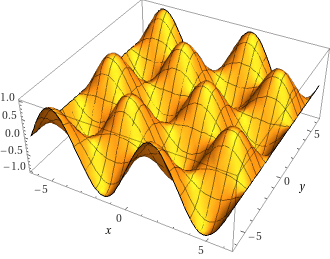

In [27]:
response = llm.invoke(
    prompt="Plot sin x cos y",
    system_prompt=system_prompt,
    tool_config=toolConfig,
    ToolsList=ToolsList
)
if type(response) is str:
    print(f"{Fore.GREEN}Response:\n {response}")
else:
    img = Image.open(io.BytesIO(response))
    img.show()

Perfect! The model was able to identify the function to be rendered and used our wolfram alpha tool to generate a plot.